In [ ]:
from sys import path
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import logging
logging.getLogger("pypsa").setLevel(logging.ERROR)

BASE_DIR = Path.cwd()
path.append(str(BASE_DIR.parent))

from custom_package.Plot_Helper_funcs import *
from custom_package.Class_funcs import *

data_file = BASE_DIR / "Timeseries_3.156_101.691_E5_1kWp_crystSi_14_0deg_-1deg_2023_2023.csv"

In [ ]:
arr = np.loadtxt(data_file, 
                 delimiter=',', 
                 skiprows=23, 
                 usecols=(1))

solar_profile = np.concatenate((np.zeros(8), arr[:-8]))/1000
solar_profile *= 1500/np.sum(solar_profile) # Scale to 1.5 MWh/year

config = {#Sen/kWh
    # "snapshots": range(len(solar_profile)),
    "holiday_arr": [0, 28, 29, 89, 90, 120, 131, 152, 157, 177, 242, 248, 257, 292, 357], # based on 2025, https://www.mytnb.com.my/tariff/index.html?v=1.1.47#faq
    "peak_hours": np.arange(13,22), # 2pm to 10pm
    "peak_profile_simplistic": False,
    "peak_profile": None, # Optional
    "grid_import_profile": np.array((np.arange(len(solar_profile)) % 24) < 8, dtype=int),
	"solar_profile": solar_profile,
    "kW_solar": 3, # kW
    "battery_efficiency": 0.9,
    "BESS_capacity": 8,
}

config["finanicials"] = {"wheeling_charge": 20, # sen/kWh
                         "electricity_price_grid": 0, # sen/kWh, already included in peak and off-peak charge
							"capacity_charge": 21.76*100, # sen/kW/month,
							"network_charge": 23.06*100, # sen/kW/month,
							"off_peak_charge": 51.09,
							"peak_charge": 55.18,
                            "peak_charge_plus": 18,
							"green_electricity_tariff": 5.0,
						 	"PV_per_kWp": 180, # MYR per kWp
                            "BESS_per_kWh": 48, # MYR per kWh
							"grid_charging_tariff": 60, # sen/kWh, IN TOTAL: inbetween 
                            "peak_quadratic_cost": 10
						 }


1500.0


<>:1: DeprecationWarning: invalid escape sequence '\D'
<>:1: DeprecationWarning: invalid escape sequence '\D'
C:\Users\royro\AppData\Local\Temp\ipykernel_31416\2569079559.py:1: DeprecationWarning: invalid escape sequence '\D'
  arr = np.loadtxt('C:\\Users\\royro\Desktop\\Solar_PPAs\\Timeseries_3.156_101.691_E5_1kWp_crystSi_14_0deg_-1deg_2023_2023.csv',


In [ ]:
solar_arr = np.arange(1, 7.5, 0.5) # kWp
BESS_arr = np.arange(0, 17, 2) # kWh

result_arr = np.zeros((len(solar_arr), len(BESS_arr)))
CRESS_arr = array = [[0 for _ in range(len(BESS_arr))] for _ in range(len(solar_arr))]
for i, solar_kW in enumerate(solar_arr):
	for j, BESS_kWh in enumerate(BESS_arr):
		config["kW_solar"] = solar_kW
		config["BESS_capacity"] = BESS_kWh

		CRESS = CRESS_network("no_grid_charging", config, label=f"CRESS with no Grid Charging, {config['kW_solar']}kW solar, {config['BESS_capacity']}kWh BESS")

		CRESS.initialize_network()

		CRESS.n.optimize(
			solver_name="highs",
			log_to_console=False,
			solver_options={
				"solver": "ipm",
				"presolve": "on",          # default, but make explicit
				"parallel": "on",
				"threads": 8,              # match your CPU cores
				"time_limit": 3600,        # seconds   
			}
		)
		total_cost = CRESS.calculate_total_costs2(print_bool=True)
		CRESS.gather_statistics()
		print(i, j, total_cost)
		result_arr[i, j] = total_cost
		CRESS_arr[i][j] = CRESS

C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: invalid value encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)


peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 85.81it/s]
INFO:linopy.io: Writing time: 1.48s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



n.objective: 4150.047039280438 
 wheeling_charge: 297.42198139042324 
 battery yearly cost: 0 
 solar yearly cost: 180.0 
 capacity charge: 537.84
0 0 5165.309020670861
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 81.06it/s]
INFO:linopy.io: Writing time: 1.61s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



n.objective: 4150.047039280438 
 wheeling_charge: 297.42198139042324 
 battery yearly cost: 96 
 solar yearly cost: 180.0 
 capacity charge: 537.84
0 1 5261.309020670861
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 74.62it/s]
INFO:linopy.io: Writing time: 1.69s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



n.objective: 4150.047039280438 
 wheeling_charge: 297.42198139042324 
 battery yearly cost: 192 
 solar yearly cost: 180.0 
 capacity charge: 537.84
0 2 5357.309020670861
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 76.80it/s]
INFO:linopy.io: Writing time: 1.72s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



n.objective: 4150.047039280438 
 wheeling_charge: 297.42198139042324 
 battery yearly cost: 288 
 solar yearly cost: 180.0 
 capacity charge: 537.84
0 3 5453.309020670861
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 73.60it/s]
INFO:linopy.io: Writing time: 1.65s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



n.objective: 4150.047039280438 
 wheeling_charge: 297.42198139042324 
 battery yearly cost: 384 
 solar yearly cost: 180.0 
 capacity charge: 537.84
0 4 5549.309020670861
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 74.84it/s]
INFO:linopy.io: Writing time: 1.62s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



n.objective: 4150.047039280438 
 wheeling_charge: 297.42198139042324 
 battery yearly cost: 480 
 solar yearly cost: 180.0 
 capacity charge: 537.84
0 5 5645.309020670861
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 71.32it/s]
INFO:linopy.io: Writing time: 1.75s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



n.objective: 4150.047039280438 
 wheeling_charge: 297.42198139042324 
 battery yearly cost: 576 
 solar yearly cost: 180.0 
 capacity charge: 537.84
0 6 5741.309020670861
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 66.32it/s]
INFO:linopy.io: Writing time: 1.67s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



n.objective: 4150.047039280438 
 wheeling_charge: 297.42198139042324 
 battery yearly cost: 672 
 solar yearly cost: 180.0 
 capacity charge: 537.84
0 7 5837.309020670861
peak
Number of peak hours in the year: 2241.0


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Class_funcs.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.config["BESS_max_hours"] = self.config["BESS_capacity"]/(self.config["kW_solar"]-1)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 69.96it/s]
INFO:linopy.io: Writing time: 1.87s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.46e+05
Solver model: available
Solver message: Optimal



n.objective: 4150.047039280438 
 wheeling_charge: 297.42198139042324 
 battery yearly cost: 768 
 solar yearly cost: 180.0 
 capacity charge: 537.84
0 8 5933.309020670861
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 71.39it/s]
INFO:linopy.io: Writing time: 1.67s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.00e+05
Solver model: available
Solver message: Optimal



n.objective: 3735.2016095016133 
 wheeling_charge: 441.709083695811 
 battery yearly cost: 0 
 solar yearly cost: 270.0 
 capacity charge: 537.84
1 0 4984.750693197425
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 62.95it/s]
INFO:linopy.io: Writing time: 1.77s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.93e+05
Solver model: available
Solver message: Optimal



n.objective: 3717.283289790503 
 wheeling_charge: 443.68958336798414 
 battery yearly cost: 96 
 solar yearly cost: 270.0 
 capacity charge: 537.84
1 1 5064.8128731584875
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 60.07it/s]
INFO:linopy.io: Writing time: 1.77s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.91e+05
Solver model: available
Solver message: Optimal



n.objective: 3719.340675625829 
 wheeling_charge: 441.5553656964915 
 battery yearly cost: 192 
 solar yearly cost: 270.0 
 capacity charge: 537.84
1 2 5160.736041322321
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 61.89it/s]
INFO:linopy.io: Writing time: 1.94s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.91e+05
Solver model: available
Solver message: Optimal



n.objective: 3720.4739688935797 
 wheeling_charge: 440.3797502735374 
 battery yearly cost: 288 
 solar yearly cost: 270.0 
 capacity charge: 537.84
1 3 5256.693719167117
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 71.42it/s]
INFO:linopy.io: Writing time: 1.9s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.90e+05
Solver model: available
Solver message: Optimal



n.objective: 3720.672534328845 
 wheeling_charge: 440.17376953155735 
 battery yearly cost: 384 
 solar yearly cost: 270.0 
 capacity charge: 537.84
1 4 5352.686303860402
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 58.09it/s]
INFO:linopy.io: Writing time: 1.86s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.90e+05
Solver model: available
Solver message: Optimal



n.objective: 3720.734040584028 
 wheeling_charge: 440.109966362273 
 battery yearly cost: 480 
 solar yearly cost: 270.0 
 capacity charge: 534.0852754252297
1 5 5444.929282371531
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 73.17it/s]
INFO:linopy.io: Writing time: 1.65s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.90e+05
Solver model: available
Solver message: Optimal



n.objective: 3720.750609167346 
 wheeling_charge: 440.0927790351728 
 battery yearly cost: 576 
 solar yearly cost: 270.0 
 capacity charge: 537.84
1 6 5544.6833882025185
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 66.01it/s]
INFO:linopy.io: Writing time: 1.78s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.90e+05
Solver model: available
Solver message: Optimal



n.objective: 3720.750609167344 
 wheeling_charge: 440.0927790351728 
 battery yearly cost: 672 
 solar yearly cost: 270.0 
 capacity charge: 537.84
1 7 5640.683388202518
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 59.23it/s]
INFO:linopy.io: Writing time: 1.72s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.90e+05
Solver model: available
Solver message: Optimal



n.objective: 3720.750609167355 
 wheeling_charge: 440.0927790351728 
 battery yearly cost: 768 
 solar yearly cost: 270.0 
 capacity charge: 537.84
1 8 5736.6833882025285
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 65.03it/s]
INFO:linopy.io: Writing time: 1.71s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.70e+05
Solver model: available
Solver message: Optimal



n.objective: 3462.908340347157 
 wheeling_charge: 536.3412365994838 
 battery yearly cost: 0 
 solar yearly cost: 360.0 
 capacity charge: 537.84
2 0 4897.089576946641
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 67.62it/s]
INFO:linopy.io: Writing time: 1.76s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.45e+05
Solver model: available
Solver message: Optimal



n.objective: 3299.325006212977 
 wheeling_charge: 588.0152855021721 
 battery yearly cost: 96 
 solar yearly cost: 360.0 
 capacity charge: 517.5690911035871
2 1 4860.909382818736
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 67.58it/s]
INFO:linopy.io: Writing time: 1.89s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.42e+05
Solver model: available
Solver message: Optimal



n.objective: 3298.2742747655598 
 wheeling_charge: 585.644067205634 
 battery yearly cost: 192 
 solar yearly cost: 360.0 
 capacity charge: 533.641675551302
2 2 4969.560017522495
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 66.67it/s]
INFO:linopy.io: Writing time: 1.88s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.40e+05
Solver model: available
Solver message: Optimal



n.objective: 3299.6764385326205 
 wheeling_charge: 583.6673393058752 
 battery yearly cost: 288 
 solar yearly cost: 360.0 
 capacity charge: 532.5149812036908
2 3 5063.858759042187
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 68.58it/s]
INFO:linopy.io: Writing time: 1.67s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.39e+05
Solver model: available
Solver message: Optimal



n.objective: 3301.357578047143 
 wheeling_charge: 581.7778763705709 
 battery yearly cost: 384 
 solar yearly cost: 360.0 
 capacity charge: 527.2126732436059
2 4 5154.34812766132
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 72.59it/s]
INFO:linopy.io: Writing time: 1.79s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.38e+05
Solver model: available
Solver message: Optimal



n.objective: 3302.909245378542 
 wheeling_charge: 580.1682629562574 
 battery yearly cost: 480 
 solar yearly cost: 360.0 
 capacity charge: 471.3952782258788
2 5 5194.472786560678
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 47.98it/s]
INFO:linopy.io: Writing time: 1.81s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.37e+05
Solver model: available
Solver message: Optimal



n.objective: 3303.8312205654993 
 wheeling_charge: 579.2118571606513 
 battery yearly cost: 576 
 solar yearly cost: 360.0 
 capacity charge: 460.26031205798483
2 6 5279.303389784135
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 71.25it/s]
INFO:linopy.io: Writing time: 1.73s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.37e+05
Solver model: available
Solver message: Optimal



n.objective: 3304.169507310149 
 wheeling_charge: 578.8609373010548 
 battery yearly cost: 672 
 solar yearly cost: 360.0 
 capacity charge: 463.1561350895831
2 7 5378.186579700787
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 63.76it/s]
INFO:linopy.io: Writing time: 1.77s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.37e+05
Solver model: available
Solver message: Optimal



n.objective: 3304.3172568968894 
 wheeling_charge: 578.7076700949011 
 battery yearly cost: 768 
 solar yearly cost: 360.0 
 capacity charge: 443.60353176468914
2 8 5454.62845875648
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 68.99it/s]
INFO:linopy.io: Writing time: 1.77s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.52e+05
Solver model: available
Solver message: Optimal



n.objective: 3306.702078016993 
 wheeling_charge: 590.55167961351 
 battery yearly cost: 0 
 solar yearly cost: 450.0 
 capacity charge: 537.84
3 0 4885.093757630503
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 68.61it/s]
INFO:linopy.io: Writing time: 1.82s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.12e+05
Solver model: available
Solver message: Optimal



n.objective: 2989.4730703159544 
 wheeling_charge: 696.75271846223 
 battery yearly cost: 96 
 solar yearly cost: 450.0 
 capacity charge: 516.9896086226679
3 1 4749.215397400852
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 67.13it/s]
INFO:linopy.io: Writing time: 1.8s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.95e+05
Solver model: available
Solver message: Optimal



n.objective: 2890.96166333024 
 wheeling_charge: 726.3502472764086 
 battery yearly cost: 192 
 solar yearly cost: 450.0 
 capacity charge: 409.69979775902095
3 2 4669.011708365669
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 57.48it/s]
INFO:linopy.io: Writing time: 1.72s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.93e+05
Solver model: available
Solver message: Optimal



n.objective: 2885.5218377491215 
 wheeling_charge: 726.3629783838129 
 battery yearly cost: 288 
 solar yearly cost: 450.0 
 capacity charge: 414.71988333998075
3 3 4764.604699472915
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 69.33it/s]
INFO:linopy.io: Writing time: 1.71s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.91e+05
Solver model: available
Solver message: Optimal



n.objective: 2884.2279450484507 
 wheeling_charge: 725.81273017508 
 battery yearly cost: 384 
 solar yearly cost: 450.0 
 capacity charge: 348.4296373661447
3 4 4792.470312589675
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 67.69it/s]
INFO:linopy.io: Writing time: 1.91s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.90e+05
Solver model: available
Solver message: Optimal



n.objective: 2884.111541390592 
 wheeling_charge: 725.0754940089665 
 battery yearly cost: 480 
 solar yearly cost: 450.0 
 capacity charge: 269.4607499401188
3 5 4808.647785339677
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 69.69it/s]
INFO:linopy.io: Writing time: 1.82s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.90e+05
Solver model: available
Solver message: Optimal



n.objective: 2884.2852939305403 
 wheeling_charge: 724.5113339302113 
 battery yearly cost: 576 
 solar yearly cost: 450.0 
 capacity charge: 191.1182629172887
3 6 4825.91489077804
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 57.97it/s]
INFO:linopy.io: Writing time: 2.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.89e+05
Solver model: available
Solver message: Optimal



n.objective: 2884.4478217572737 
 wheeling_charge: 724.1453671825029 
 battery yearly cost: 672 
 solar yearly cost: 450.0 
 capacity charge: 148.95739711222396
3 7 4879.550586052
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 60.82it/s]
INFO:linopy.io: Writing time: 1.83s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.89e+05
Solver model: available
Solver message: Optimal



n.objective: 2884.574016760252 
 wheeling_charge: 723.933959198317 
 battery yearly cost: 768 
 solar yearly cost: 450.0 
 capacity charge: 143.57051368523005
3 8 4970.078489643799
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 39.22it/s]
INFO:linopy.io: Writing time: 1.85s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.41e+05
Solver model: available
Solver message: Optimal



n.objective: 3204.8125372587638 
 wheeling_charge: 625.9082665040509 
 battery yearly cost: 0 
 solar yearly cost: 540.0 
 capacity charge: 537.84
4 0 4908.560803762815
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 56.76it/s]
INFO:linopy.io: Writing time: 1.87s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.95e+05
Solver model: available
Solver message: Optimal



n.objective: 2833.424583433699 
 wheeling_charge: 751.3920265559178 
 battery yearly cost: 96 
 solar yearly cost: 540.0 
 capacity charge: 431.0687051932706
4 1 4651.885315182888
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 49.24it/s]
INFO:linopy.io: Writing time: 1.95s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.62e+05
Solver model: available
Solver message: Optimal



n.objective: 2579.1639783095907 
 wheeling_charge: 835.6132013323194 
 battery yearly cost: 192 
 solar yearly cost: 540.0 
 capacity charge: 328.2216741188051
4 2 4474.998853760715
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 71.44it/s]
INFO:linopy.io: Writing time: 1.67s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.50e+05
Solver model: available
Solver message: Optimal



n.objective: 2488.8562990723312 
 wheeling_charge: 865.6458982561373 
 battery yearly cost: 288 
 solar yearly cost: 540.0 
 capacity charge: 236.52934715897825
4 3 4419.031544487447
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 56.36it/s]
INFO:linopy.io: Writing time: 2.13s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.49e+05
Solver model: available
Solver message: Optimal



n.objective: 2478.711589230682 
 wheeling_charge: 868.6798595586733 
 battery yearly cost: 384 
 solar yearly cost: 540.0 
 capacity charge: 147.47102778225565
4 4 4418.862476571612
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 58.38it/s]
INFO:linopy.io: Writing time: 2.47s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.48e+05
Solver model: available
Solver message: Optimal



n.objective: 2476.809869425813 
 wheeling_charge: 869.1055418561544 
 battery yearly cost: 480 
 solar yearly cost: 540.0 
 capacity charge: 81.39597141113678
4 5 4447.311382693104
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 63.75it/s]
INFO:linopy.io: Writing time: 2.27s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.48e+05
Solver model: available
Solver message: Optimal



n.objective: 2475.503018808333 
 wheeling_charge: 869.3995307700396 
 battery yearly cost: 576 
 solar yearly cost: 540.0 
 capacity charge: 27.6355335418652
4 6 4488.5380831202365
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 53.71it/s]
INFO:linopy.io: Writing time: 2.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.48e+05
Solver model: available
Solver message: Optimal



n.objective: 2474.7906090152946 
 wheeling_charge: 869.5970683894586 
 battery yearly cost: 672 
 solar yearly cost: 540.0 
 capacity charge: 13.858503363320322
4 7 4570.246180768073
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 45.99it/s]
INFO:linopy.io: Writing time: 2.2s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.47e+05
Solver model: available
Solver message: Optimal



n.objective: 2474.316795123376 
 wheeling_charge: 869.7383454791852 
 battery yearly cost: 768 
 solar yearly cost: 540.0 
 capacity charge: 1.9156741748141186
4 8 4653.9708147773745
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 45.46it/s]
INFO:linopy.io: Writing time: 2.23s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.33e+05
Solver model: available
Solver message: Optimal



n.objective: 3131.1243017658126 
 wheeling_charge: 651.435372429692 
 battery yearly cost: 0 
 solar yearly cost: 630.0 
 capacity charge: 537.84
5 0 4950.399674195505
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 65.88it/s]
INFO:linopy.io: Writing time: 1.74s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.85e+05
Solver model: available
Solver message: Optimal



n.objective: 2742.8739757751196 
 wheeling_charge: 782.9566631854542 
 battery yearly cost: 96 
 solar yearly cost: 630.0 
 capacity charge: 417.6012501698147
5 1 4669.431889130388
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 70.56it/s]
INFO:linopy.io: Writing time: 1.88s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.44e+05
Solver model: available
Solver message: Optimal



n.objective: 2411.07473538596 
 wheeling_charge: 894.6478591190654 
 battery yearly cost: 192 
 solar yearly cost: 630.0 
 capacity charge: 280.2159751291449
5 2 4407.938569634171
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 60.00it/s]
INFO:linopy.io: Writing time: 2.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.19e+05
Solver model: available
Solver message: Optimal



n.objective: 2189.4901694430773 
 wheeling_charge: 971.7189909995046 
 battery yearly cost: 288 
 solar yearly cost: 630.0 
 capacity charge: 136.76634153068903
5 3 4215.975501973271
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 70.80it/s]
INFO:linopy.io: Writing time: 2.0s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.10e+05
Solver model: available
Solver message: Optimal



n.objective: 2097.471830237456 
 wheeling_charge: 1004.2944126055394 
 battery yearly cost: 384 
 solar yearly cost: 630.0 
 capacity charge: 59.89862325177483
5 4 4175.66486609477
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 47.21it/s]
INFO:linopy.io: Writing time: 2.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.08e+05
Solver model: available
Solver message: Optimal



n.objective: 2083.431053700309 
 wheeling_charge: 1009.1626141818628 
 battery yearly cost: 480 
 solar yearly cost: 630.0 
 capacity charge: 16.763878843696425
5 5 4219.357546725868
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 55.79it/s]
INFO:linopy.io: Writing time: 2.18s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.08e+05
Solver model: available
Solver message: Optimal



n.objective: 2082.381725567123 
 wheeling_charge: 1009.4855676351522 
 battery yearly cost: 576 
 solar yearly cost: 630.0 
 capacity charge: 0.0
5 6 4297.867293202275
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 60.37it/s]
INFO:linopy.io: Writing time: 1.79s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.08e+05
Solver model: available
Solver message: Optimal



n.objective: 2081.8494670530235 
 wheeling_charge: 1009.6753549462939 
 battery yearly cost: 672 
 solar yearly cost: 630.0 
 capacity charge: 0.0
5 7 4393.524821999317
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 70.28it/s]
INFO:linopy.io: Writing time: 1.85s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.08e+05
Solver model: available
Solver message: Optimal



n.objective: 2081.5055838713383 
 wheeling_charge: 1009.797973303109 
 battery yearly cost: 768 
 solar yearly cost: 630.0 
 capacity charge: 0.0
5 8 4489.303557174447
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 60.58it/s]
INFO:linopy.io: Writing time: 1.86s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.26e+05
Solver model: available
Solver message: Optimal



n.objective: 3074.9401881190797 
 wheeling_charge: 670.9100753852335 
 battery yearly cost: 0 
 solar yearly cost: 720.0 
 capacity charge: 537.84
6 0 5003.690263504313
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 51.93it/s]
INFO:linopy.io: Writing time: 2.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.78e+05
Solver model: available
Solver message: Optimal



n.objective: 2680.2422947913933 
 wheeling_charge: 804.7598692716953 
 battery yearly cost: 96 
 solar yearly cost: 720.0 
 capacity charge: 405.7363631903364
6 1 4706.738527253426
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 63.46it/s]
INFO:linopy.io: Writing time: 1.87s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.34e+05
Solver model: available
Solver message: Optimal



n.objective: 2315.0293245742982 
 wheeling_charge: 928.3410405399029 
 battery yearly cost: 192 
 solar yearly cost: 720.0 
 capacity charge: 243.44795041025912
6 2 4398.81831552446
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 60.82it/s]
INFO:linopy.io: Writing time: 1.77s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.02e+05
Solver model: available
Solver message: Optimal



n.objective: 2016.3011652296989 
 wheeling_charge: 1033.310292767716 
 battery yearly cost: 288 
 solar yearly cost: 720.0 
 capacity charge: 88.26379206569582
6 3 4145.875250063111
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 53.08it/s]
INFO:linopy.io: Writing time: 2.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.81e+05
Solver model: available
Solver message: Optimal



n.objective: 1811.92714416389 
 wheeling_charge: 1106.0112197549847 
 battery yearly cost: 384 
 solar yearly cost: 720.0 
 capacity charge: 36.63541727678606
6 4 4058.5737811956606
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 68.19it/s]
INFO:linopy.io: Writing time: 1.71s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.72e+05
Solver model: available
Solver message: Optimal



n.objective: 1717.0110224426585 
 wheeling_charge: 1139.7701250979035 
 battery yearly cost: 480 
 solar yearly cost: 720.0 
 capacity charge: 1.9315462824334688
6 5 4058.7126938229953
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 69.82it/s]
INFO:linopy.io: Writing time: 1.84s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.70e+05
Solver model: available
Solver message: Optimal



n.objective: 1697.5516691408816 
 wheeling_charge: 1146.7043433264573 
 battery yearly cost: 576 
 solar yearly cost: 720.0 
 capacity charge: 0.0
6 6 4140.256012467339
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 22.03it/s]
INFO:linopy.io: Writing time: 2.21s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.70e+05
Solver model: available
Solver message: Optimal



n.objective: 1696.3837007683605 
 wheeling_charge: 1147.1208055737457 
 battery yearly cost: 672 
 solar yearly cost: 720.0 
 capacity charge: 0.0
6 7 4235.504506342106
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 46.15it/s]
INFO:linopy.io: Writing time: 2.21s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.70e+05
Solver model: available
Solver message: Optimal



n.objective: 1696.2979851588602 
 wheeling_charge: 1147.1513691713565 
 battery yearly cost: 768 
 solar yearly cost: 720.0 
 capacity charge: 0.0
6 8 4331.449354330216
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 48.89it/s]
INFO:linopy.io: Writing time: 2.76s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.22e+05
Solver model: available
Solver message: Optimal



n.objective: 3031.326433287738 
 wheeling_charge: 686.0635251102761 
 battery yearly cost: 0 
 solar yearly cost: 810.0 
 capacity charge: 537.84
7 0 5065.229958398014
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 57.69it/s]
INFO:linopy.io: Writing time: 2.09s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.73e+05
Solver model: available
Solver message: Optimal



n.objective: 2632.0337389371657 
 wheeling_charge: 821.5580898268198 
 battery yearly cost: 96 
 solar yearly cost: 810.0 
 capacity charge: 401.2339265278911
7 1 4760.825755291877
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 65.55it/s]
INFO:linopy.io: Writing time: 2.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.27e+05
Solver model: available
Solver message: Optimal



n.objective: 2252.762972667233 
 wheeling_charge: 950.1833217149958 
 battery yearly cost: 192 
 solar yearly cost: 810.0 
 capacity charge: 208.06849755312632
7 2 4413.014791935356
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 49.93it/s]
INFO:linopy.io: Writing time: 2.26s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.92e+05
Solver model: available
Solver message: Optimal



n.objective: 1915.3893222460663 
 wheeling_charge: 1069.2332335052433 
 battery yearly cost: 288 
 solar yearly cost: 810.0 
 capacity charge: 87.22281900082123
7 3 4169.845374752131
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 54.62it/s]
INFO:linopy.io: Writing time: 2.11s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.64e+05
Solver model: available
Solver message: Optimal



n.objective: 1636.6017588659702 
 wheeling_charge: 1168.4883657141718 
 battery yearly cost: 384 
 solar yearly cost: 810.0 
 capacity charge: 25.224899235936316
7 4 4024.3150238160783
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 60.54it/s]
INFO:linopy.io: Writing time: 2.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.44e+05
Solver model: available
Solver message: Optimal



n.objective: 1443.0883721571763 
 wheeling_charge: 1237.4382698672723 
 battery yearly cost: 480 
 solar yearly cost: 810.0 
 capacity charge: 0.0
7 5 3970.5266420244484
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 63.15it/s]
INFO:linopy.io: Writing time: 2.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.34e+05
Solver model: available
Solver message: Optimal



n.objective: 1343.2902655969724 
 wheeling_charge: 1273.0232606179268 
 battery yearly cost: 576 
 solar yearly cost: 810.0 
 capacity charge: 0.0
7 6 4002.313526214899
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 61.40it/s]
INFO:linopy.io: Writing time: 1.84s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.32e+05
Solver model: available
Solver message: Optimal



n.objective: 1316.6492686710646 
 wheeling_charge: 1282.5226355246516 
 battery yearly cost: 672 
 solar yearly cost: 810.0 
 capacity charge: 0.0
7 7 4081.1719041957163
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 54.01it/s]
INFO:linopy.io: Writing time: 2.2s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.31e+05
Solver model: available
Solver message: Optimal



n.objective: 1313.6055258544668 
 wheeling_charge: 1283.6079422875673 
 battery yearly cost: 768 
 solar yearly cost: 810.0 
 capacity charge: 0.0
7 8 4175.213468142034
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 45.42it/s]
INFO:linopy.io: Writing time: 2.45s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.18e+05
Solver model: available
Solver message: Optimal



n.objective: 2996.141064092099 
 wheeling_charge: 698.3041462241864 
 battery yearly cost: 0 
 solar yearly cost: 900.0 
 capacity charge: 537.84
8 0 5132.285210316286
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 61.45it/s]
INFO:linopy.io: Writing time: 2.35s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.69e+05
Solver model: available
Solver message: Optimal



n.objective: 2594.1705125566077 
 wheeling_charge: 834.7457657808883 
 battery yearly cost: 96 
 solar yearly cost: 900.0 
 capacity charge: 400.8593696520949
8 1 4825.775647989591
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 53.37it/s]
INFO:linopy.io: Writing time: 2.58s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.22e+05
Solver model: available
Solver message: Optimal



n.objective: 2207.4999041751084 
 wheeling_charge: 966.0599547075999 
 battery yearly cost: 192 
 solar yearly cost: 900.0 
 capacity charge: 177.9757842394897
8 2 4443.535643122197
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 58.71it/s]
INFO:linopy.io: Writing time: 2.26s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.85e+05
Solver model: available
Solver message: Optimal



n.objective: 1852.3844159937205 
 wheeling_charge: 1091.643929403687 
 battery yearly cost: 288 
 solar yearly cost: 900.0 
 capacity charge: 66.36420765079532
8 3 4198.392553048203
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 38.07it/s]
INFO:linopy.io: Writing time: 2.83s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.53e+05
Solver model: available
Solver message: Optimal



n.objective: 1530.61832480179 
 wheeling_charge: 1206.2517055890607 
 battery yearly cost: 384 
 solar yearly cost: 900.0 
 capacity charge: 11.744170614431686
8 4 4032.6142010052827
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 49.34it/s]
INFO:linopy.io: Writing time: 2.57s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.27e+05
Solver model: available
Solver message: Optimal



n.objective: 1265.328475810295 
 wheeling_charge: 1300.8220802958301 
 battery yearly cost: 480 
 solar yearly cost: 900.0 
 capacity charge: 0.0
8 5 3946.150556106125
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 41.36it/s]
INFO:linopy.io: Writing time: 2.37s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.08e+05
Solver model: available
Solver message: Optimal



n.objective: 1078.1823573252038 
 wheeling_charge: 1367.5527340612437 
 battery yearly cost: 576 
 solar yearly cost: 900.0 
 capacity charge: 0.0
8 6 3921.7350913864475
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 52.79it/s]
INFO:linopy.io: Writing time: 2.32s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 9.73e+04
Solver model: available
Solver message: Optimal



n.objective: 973.0870297879784 
 wheeling_charge: 1405.0265538284862 
 battery yearly cost: 672 
 solar yearly cost: 900.0 
 capacity charge: 0.0
8 7 3950.1135836164644
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 55.83it/s]
INFO:linopy.io: Writing time: 2.09s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 9.46e+04
Solver model: available
Solver message: Optimal



n.objective: 946.2681860229347 
 wheeling_charge: 1414.5893435468117 
 battery yearly cost: 768 
 solar yearly cost: 900.0 
 capacity charge: 0.0
8 8 4028.8575295697465
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 68.25it/s]
INFO:linopy.io: Writing time: 2.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.14e+05
Solver model: available
Solver message: Optimal



n.objective: 2966.416787852918 
 wheeling_charge: 708.6500307349976 
 battery yearly cost: 0 
 solar yearly cost: 990.0 
 capacity charge: 537.84
9 0 5202.906818587916
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 60.56it/s]
INFO:linopy.io: Writing time: 2.45s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.66e+05
Solver model: available
Solver message: Optimal



n.objective: 2562.690251792748 
 wheeling_charge: 845.7063985815004 
 battery yearly cost: 96 
 solar yearly cost: 990.0 
 capacity charge: 366.0020038724752
9 1 4860.398654246723
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 53.33it/s]
INFO:linopy.io: Writing time: 1.99s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.18e+05
Solver model: available
Solver message: Optimal



n.objective: 2170.4690071690716 
 wheeling_charge: 979.0572053473369 
 battery yearly cost: 192 
 solar yearly cost: 990.0 
 capacity charge: 163.00679888191866
9 2 4494.533011398326
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 51.31it/s]
INFO:linopy.io: Writing time: 2.22s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.81e+05
Solver model: available
Solver message: Optimal



n.objective: 1806.1714022235378 
 wheeling_charge: 1108.070916880945 
 battery yearly cost: 288 
 solar yearly cost: 990.0 
 capacity charge: 55.16870224088555
9 3 4247.41102134537
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 48.91it/s]
INFO:linopy.io: Writing time: 2.09s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.46e+05
Solver model: available
Solver message: Optimal



n.objective: 1464.1991451833333 
 wheeling_charge: 1229.9198147899594 
 battery yearly cost: 384 
 solar yearly cost: 990.0 
 capacity charge: 4.614553567487213
9 4 4072.73351354078
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 52.83it/s]
INFO:linopy.io: Writing time: 2.25s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.15e+05
Solver model: available
Solver message: Optimal



n.objective: 1154.801709042227 
 wheeling_charge: 1340.2325872553863 
 battery yearly cost: 480 
 solar yearly cost: 990.0 
 capacity charge: 0.0
9 5 3965.0342962976133
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 61.79it/s]
INFO:linopy.io: Writing time: 2.16s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 9.00e+04
Solver model: available
Solver message: Optimal



n.objective: 899.7774338819418 
 wheeling_charge: 1431.1665416716098 
 battery yearly cost: 576 
 solar yearly cost: 990.0 
 capacity charge: 0.0
9 6 3896.943975553552
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 40.94it/s]
INFO:linopy.io: Writing time: 2.52s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 7.16e+04
Solver model: available
Solver message: Optimal



n.objective: 716.0729885375056 
 wheeling_charge: 1496.669998738626 
 battery yearly cost: 672 
 solar yearly cost: 990.0 
 capacity charge: 0.0
9 7 3874.7429872761318
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 50.93it/s]
INFO:linopy.io: Writing time: 2.19s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 6.57e+04
Solver model: available
Solver message: Optimal



n.objective: 656.9687178404454 
 wheeling_charge: 1517.7447966338168 
 battery yearly cost: 768 
 solar yearly cost: 990.0 
 capacity charge: 0.0
9 8 3932.713514474262
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 58.20it/s]
INFO:linopy.io: Writing time: 2.27s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.12e+05
Solver model: available
Solver message: Optimal



n.objective: 2941.1351455440017 
 wheeling_charge: 717.4499412156829 
 battery yearly cost: 0 
 solar yearly cost: 1080.0 
 capacity charge: 537.84
10 0 5276.425086759685
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 49.51it/s]
INFO:linopy.io: Writing time: 2.46s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.63e+05
Solver model: available
Solver message: Optimal



n.objective: 2535.918380014698 
 wheeling_charge: 855.0241104271926 
 battery yearly cost: 96 
 solar yearly cost: 1080.0 
 capacity charge: 341.8274609612253
10 1 4908.769951403116
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 52.08it/s]
INFO:linopy.io: Writing time: 2.56s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.15e+05
Solver model: available
Solver message: Optimal



n.objective: 2140.704924155956 
 wheeling_charge: 989.5087403559127 
 battery yearly cost: 192 
 solar yearly cost: 1080.0 
 capacity charge: 143.4186578403742
10 2 4545.632322352242
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 55.37it/s]
INFO:linopy.io: Writing time: 2.43s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.77e+05
Solver model: available
Solver message: Optimal



n.objective: 1770.7072089967248 
 wheeling_charge: 1120.6856178513483 
 battery yearly cost: 288 
 solar yearly cost: 1080.0 
 capacity charge: 29.61502573270256
10 3 4289.007852580775
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 44.28it/s]
INFO:linopy.io: Writing time: 2.71s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.42e+05
Solver model: available
Solver message: Optimal



n.objective: 1415.9597184587165 
 wheeling_charge: 1247.113053099513 
 battery yearly cost: 384 
 solar yearly cost: 1080.0 
 capacity charge: 0.7809485673272314
10 4 4127.853720125557
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 38.69it/s]
INFO:linopy.io: Writing time: 2.57s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.08e+05
Solver model: available
Solver message: Optimal



n.objective: 1083.2525623102936 
 wheeling_charge: 1365.7448520911628 
 battery yearly cost: 480 
 solar yearly cost: 1080.0 
 capacity charge: 0.0
10 5 4008.9974144014564
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 46.09it/s]
INFO:linopy.io: Writing time: 2.71s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 7.84e+04
Solver model: available
Solver message: Optimal



n.objective: 783.9151189579314 
 wheeling_charge: 1472.4795439622203 
 battery yearly cost: 576 
 solar yearly cost: 1080.0 
 capacity charge: 0.0
10 6 3912.394662920152
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 40.39it/s]
INFO:linopy.io: Writing time: 2.74s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 5.37e+04
Solver model: available
Solver message: Optimal



n.objective: 537.392214697793 
 wheeling_charge: 1560.3821662692806 
 battery yearly cost: 672 
 solar yearly cost: 1080.0 
 capacity charge: 0.0
10 7 3849.7743809670733
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 50.80it/s]
INFO:linopy.io: Writing time: 2.72s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.54e+04
Solver model: available
Solver message: Optimal



n.objective: 453.9420047411734 
 wheeling_charge: 1590.1379908214726 
 battery yearly cost: 768 
 solar yearly cost: 1080.0 
 capacity charge: 0.0
10 8 3892.0799955626458
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 35.20it/s]
INFO:linopy.io: Writing time: 2.69s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.09e+05
Solver model: available
Solver message: Optimal



n.objective: 2919.560989916267 
 wheeling_charge: 724.9561345621685 
 battery yearly cost: 0 
 solar yearly cost: 1170.0 
 capacity charge: 537.84
11 0 5352.357124478435
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 55.26it/s]
INFO:linopy.io: Writing time: 2.68s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.60e+05
Solver model: available
Solver message: Optimal



n.objective: 2513.2912771211777 
 wheeling_charge: 862.90481123223 
 battery yearly cost: 96 
 solar yearly cost: 1170.0 
 capacity charge: 366.85028912498166
11 1 5009.04637747839
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 46.70it/s]
INFO:linopy.io: Writing time: 3.7s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.12e+05
Solver model: available
Solver message: Optimal



n.objective: 2116.1736805648998 
 wheeling_charge: 998.1270240972475 
 battery yearly cost: 192 
 solar yearly cost: 1170.0 
 capacity charge: 141.97412147802984
11 2 4618.2748261401775
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 43.06it/s]
INFO:linopy.io: Writing time: 2.7s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.74e+05
Solver model: available
Solver message: Optimal



n.objective: 1741.3714241031432 
 wheeling_charge: 1131.1199531688344 
 battery yearly cost: 288 
 solar yearly cost: 1170.0 
 capacity charge: 17.380136398605575
11 3 4347.871513670583
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 45.91it/s]
INFO:linopy.io: Writing time: 2.63s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.38e+05
Solver model: available
Solver message: Optimal



n.objective: 1379.345681362082 
 wheeling_charge: 1260.1669882823542 
 battery yearly cost: 384 
 solar yearly cost: 1170.0 
 capacity charge: 0.0
11 4 4193.512669644437
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 45.14it/s]
INFO:linopy.io: Writing time: 2.63s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.03e+05
Solver model: available
Solver message: Optimal



n.objective: 1033.0346171543188 
 wheeling_charge: 1383.6510546784257 
 battery yearly cost: 480 
 solar yearly cost: 1170.0 
 capacity charge: 0.0
11 5 4066.6856718327444
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 49.84it/s]
INFO:linopy.io: Writing time: 2.64s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 7.08e+04
Solver model: available
Solver message: Optimal



n.objective: 707.5698030490508 
 wheeling_charge: 1499.7019778751758 
 battery yearly cost: 576 
 solar yearly cost: 1170.0 
 capacity charge: 0.0
11 6 3953.2717809242267
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 35.23it/s]
INFO:linopy.io: Writing time: 2.79s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 4.17e+04
Solver model: available
Solver message: Optimal



n.objective: 416.996930741941 
 wheeling_charge: 1603.3114884143538 
 battery yearly cost: 672 
 solar yearly cost: 1170.0 
 capacity charge: 0.0
11 7 3862.308419156295
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 39.68it/s]
INFO:linopy.io: Writing time: 2.63s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.18e+04
Solver model: available
Solver message: Optimal



n.objective: 317.89082007130787 
 wheeling_charge: 1638.6497343300741 
 battery yearly cost: 768 
 solar yearly cost: 1170.0 
 capacity charge: 0.0
11 8 3894.540554401382
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 37.61it/s]
INFO:linopy.io: Writing time: 2.96s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.07e+05
Solver model: available
Solver message: Optimal



n.objective: 2900.753002115462 
 wheeling_charge: 731.4957766569322 
 battery yearly cost: 0 
 solar yearly cost: 1260.0 
 capacity charge: 537.84
12 0 5430.088778772394
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 43.33it/s]
INFO:linopy.io: Writing time: 2.6s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.58e+05
Solver model: available
Solver message: Optimal



n.objective: 2493.759195775622 
 wheeling_charge: 869.7031775452846 
 battery yearly cost: 96 
 solar yearly cost: 1260.0 
 capacity charge: 343.2034695453387
12 1 5062.665842866245
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 44.75it/s]
INFO:linopy.io: Writing time: 2.79s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.10e+05
Solver model: available
Solver message: Optimal



n.objective: 2095.219792815111 
 wheeling_charge: 1005.4876908838735 
 battery yearly cost: 192 
 solar yearly cost: 1260.0 
 capacity charge: 118.44645878308343
12 2 4671.153942482068
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 31.49it/s]
INFO:linopy.io: Writing time: 2.6s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.72e+05
Solver model: available
Solver message: Optimal



n.objective: 1717.3241366841667 
 wheeling_charge: 1139.674963159269 
 battery yearly cost: 288 
 solar yearly cost: 1260.0 
 capacity charge: 10.117556712257022
12 3 4415.116656555694
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 40.55it/s]
INFO:linopy.io: Writing time: 2.81s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 1.35e+05
Solver model: available
Solver message: Optimal



n.objective: 1350.1909018807269 
 wheeling_charge: 1270.5627021284429 
 battery yearly cost: 384 
 solar yearly cost: 1260.0 
 capacity charge: 0.0
12 4 4264.753604009169
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 43.83it/s]
INFO:linopy.io: Writing time: 2.69s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 9.93e+04
Solver model: available
Solver message: Optimal



n.objective: 993.4986344522034 
 wheeling_charge: 1397.7483920655236 
 battery yearly cost: 480 
 solar yearly cost: 1260.0 
 capacity charge: 0.0
12 5 4131.247026517727
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 42.24it/s]
INFO:linopy.io: Writing time: 3.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 6.54e+04
Solver model: available
Solver message: Optimal



n.objective: 654.4657413885959 
 wheeling_charge: 1518.6372824429977 
 battery yearly cost: 576 
 solar yearly cost: 1260.0 
 capacity charge: 0.0
12 6 4009.1030238315934
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 43.65it/s]
INFO:linopy.io: Writing time: 2.77s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 3.36e+04
Solver model: available
Solver message: Optimal



n.objective: 335.87165847890856 
 wheeling_charge: 1632.2383104015298 
 battery yearly cost: 672 
 solar yearly cost: 1260.0 
 capacity charge: 0.0
12 7 3900.109968880439
peak
Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 51.95it/s]
INFO:linopy.io: Writing time: 2.89s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.33e+04
Solver model: available
Solver message: Optimal



n.objective: 233.01815937884555 
 wheeling_charge: 1668.912761854575 
 battery yearly cost: 768 
 solar yearly cost: 1260.0 
 capacity charge: 0.0
12 8 3929.93092123342


97
Optimal config: 6.0 kWp solar, 14 kWh BESS, cost: 3849.7743809670733 RM/year
Optimal config: 3.0 kWp solar, 6 kWh BESS, cost: 4419.031544487447 RM/year


C:\Users/royro/Desktop/Solar_PPAs\custom_package\Plot_Helper_funcs.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\royro\AppData\Local\Temp\ipykernel_31416\605641533.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


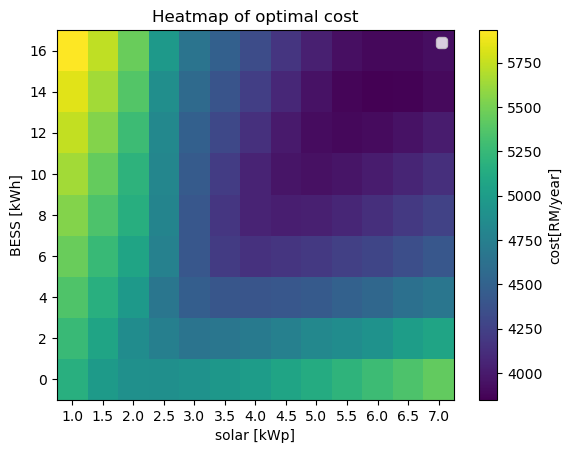

In [ ]:
produce_heatmap(result_arr, solar_arr, BESS_arr, x_label='solar [kWp]', y_label='BESS [kWh]', z_label='cost[RM/year]', title_str='Heatmap of optimal cost')

a = np.argmin(np.array(result_arr))
print(a)
i_opt, j_opt = np.unravel_index(a, result_arr.shape)
print(f"Optimal config: {solar_arr[i_opt]} kWp solar, {BESS_arr[j_opt]} kWh BESS, cost: {result_arr[i_opt, j_opt]} RM/year")

plt.legend()
plt.show()

curtailment 6.466103831094652 %


(array([<Axes: title={'center': 'average day of: CRESS with no Grid Charging, 6.0kW solar, 14kWh BESS'}, ylabel='Power (kW)'>,
        <Axes: xlabel='Hour of the day', ylabel='Battery Charge (kWh)'>],
       dtype=object),
 <Figure size 1200x800 with 2 Axes>)

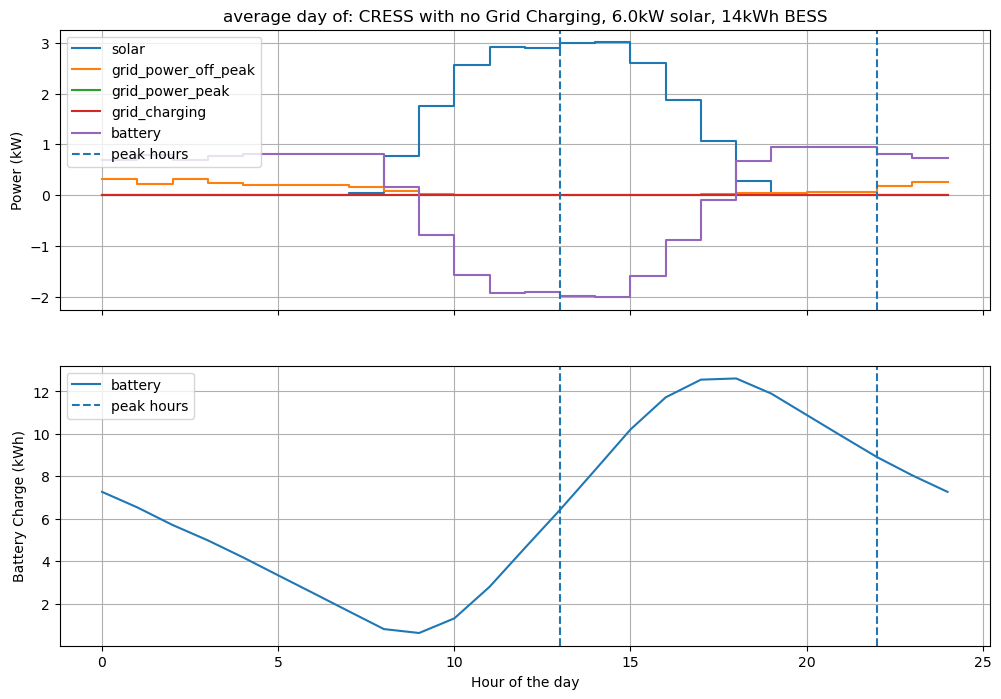

In [ ]:
CRESS_opt = CRESS_arr[i_opt][j_opt]

print("curtailment", CRESS_opt.stats["solar_curtailment"]/(np.sum(solar_profile)*config["kW_solar"])*100, "%")
print("grid usage", np.sum(CRESS_opt.n.generators_t.p['grid_power_peak'])+np.sum(CRESS_opt.n.generators_t.p['grid_power_off_peak'])/8760*100, "%")

CRESS_opt.plot_average_day()

C:\Users\royro\AppData\Local\Temp\ipykernel_31416\1825148331.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


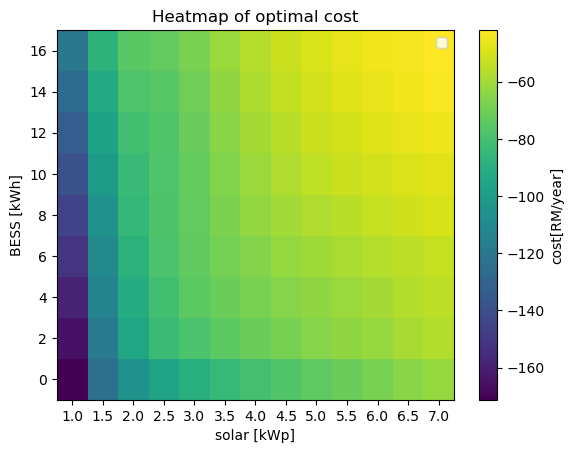

In [5]:
savings_arr = np.zeros((len(solar_arr), len(BESS_arr)))
for i in range(len(solar_arr)):
	for j in range(len(BESS_arr)):
		C = CRESS_arr[i][j]
		savings_arr[i, j] = 100*(result_arr[i, j]-7712)/C.stats["total_solar_production"]

produce_heatmap(savings_arr, solar_arr, BESS_arr, x_label='solar [kWp]', y_label='BESS [kWh]', z_label='cost[RM/year]', title_str='Heatmap of optimal cost')
plt.legend()
# plt.show()

C:\Users\royro\AppData\Local\Temp\ipykernel_31416\2553990815.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


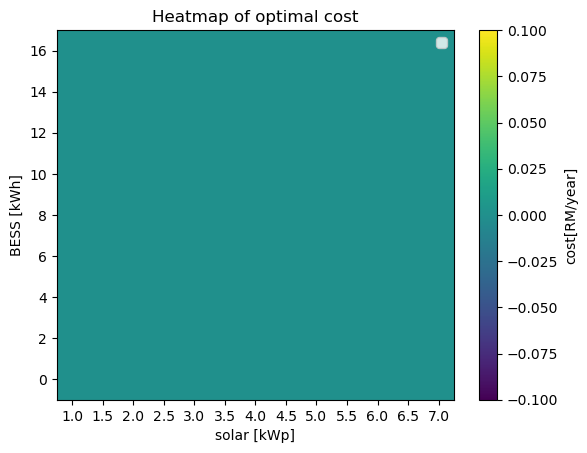

In [6]:
grid_charging_arr = np.zeros((len(solar_arr), len(BESS_arr)))
for i in range(len(solar_arr)):
	for j in range(len(BESS_arr)):
		C = CRESS_arr[i][j]
		grid_charging_arr[i, j] = C.stats["total_grid_charging"]

produce_heatmap(grid_charging_arr, solar_arr, BESS_arr, x_label='solar [kWp]', y_label='BESS [kWh]', z_label='cost[RM/year]', title_str='Heatmap of optimal cost')
plt.legend()

n.objective: 3301.357578047143 
 wheeling_charge: 581.7778763705709 
 battery yearly cost: 768 
 solar yearly cost: 1260.0 
 capacity charge: 527.2126732436059
6438.34812766132
11.762888738143817


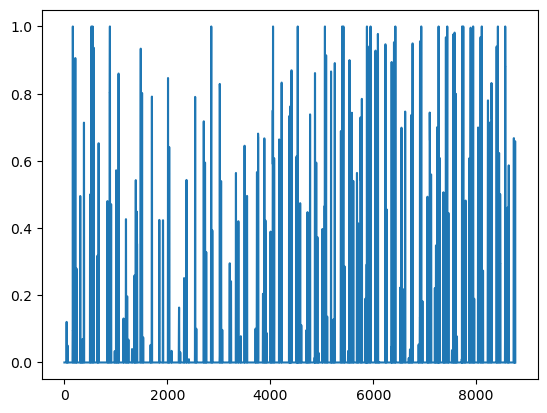

In [7]:
C = CRESS_arr[2][4]

plt.plot(C.n.generators_t.p["grid_power_peak"])
# C.calculate_total_capacity_charge()
# C.calculate_total_costs()
print(np.sum(C.calculate_total_costs()))

print(np.sum(C.finanicials["max_grid_demand_month"]))


